In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scripts.ksplot import make_ks_plot

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
with np.load("root_files/combined_test_tracks.npz") as f:
    X_train = f['features']
    y_train = f['labels']
    features = list(f['names'])
    
with np.load("root_files/combined_validate_tracks.npz") as f:
    X_test = f['features']
    y_test = f['labels']

In [4]:
# X_train = np.swapaxes(X_train,1,2)
# X_test = np.swapaxes(X_test,1,2)
# X_train = X_train.reshape((X_train.shape[0],10,28))
# X_test = X_test.reshape((X_test.shape[0],10,28))

In [5]:
model = Sequential()
model.add(Flatten(input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(units=560,activation='relu'))
model.add(Dense(units=280,activation='relu'))
model.add(Dense(units=140,activation='relu'))
model.add(Dense(units=2,activation='softmax'))
opt = keras.optimizers.SGD(1e-2)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 280)               0         
                                                                 
 batch_normalization (BatchN  (None, 280)              1120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 560)               157360    
                                                                 
 dense_1 (Dense)             (None, 280)               157080    
                                                                 
 dense_2 (Dense)             (None, 140)               39340     
                                                                 
 dense_3 (Dense)             (None, 2)                 282       
                                                        

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

In [7]:
history = model.fit(X_train, y_train, batch_size=2048, 
                               epochs=100, shuffle=False, callbacks = callbacks, 
                               validation_data=(X_test,y_test))

Epoch 1/100
  1/218 [..............................] - ETA: 36s - loss: 0.7313 - accuracy: 0.5117

2022-11-30 16:49:36.564597: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


218/218 [==============================] - 4s 20ms/step - loss: 0.4994 - accuracy: 0.7616 - val_loss: 0.4553 - val_accuracy: 0.7921
Epoch 2/100
218/218 [==============================] - 4s 20ms/step - loss: 0.4097 - accuracy: 0.8111 - val_loss: 0.4094 - val_accuracy: 0.8111
Epoch 3/100
218/218 [==============================] - 4s 20ms/step - loss: 0.3855 - accuracy: 0.8234 - val_loss: 0.3885 - val_accuracy: 0.8222
Epoch 4/100
218/218 [==============================] - 4s 20ms/step - loss: 0.3699 - accuracy: 0.8319 - val_loss: 0.3726 - val_accuracy: 0.8310
Epoch 5/100
218/218 [==============================] - 5s 21ms/step - loss: 0.3577 - accuracy: 0.8384 - val_loss: 0.3615 - val_accuracy: 0.8368
Epoch 6/100
218/218 [==============================] - 5s 21ms/step - loss: 0.3476 - accuracy: 0.8439 - val_loss: 0.3525 - val_accuracy: 0.8417
Epoch 7/100
218/218 [==============================] - 4s 20ms/step - loss: 0.3389 - accuracy: 0.8485 - val_loss: 0.3448 - val_accuracy: 0.8456
Epoc

218/218 [==============================] - 5s 23ms/step - loss: 0.2334 - accuracy: 0.9021 - val_loss: 0.2607 - val_accuracy: 0.8881
Epoch 58/100
218/218 [==============================] - 5s 23ms/step - loss: 0.2327 - accuracy: 0.9025 - val_loss: 0.2604 - val_accuracy: 0.8883
Epoch 59/100
218/218 [==============================] - 5s 23ms/step - loss: 0.2320 - accuracy: 0.9029 - val_loss: 0.2600 - val_accuracy: 0.8886
Epoch 60/100
218/218 [==============================] - 5s 21ms/step - loss: 0.2313 - accuracy: 0.9032 - val_loss: 0.2597 - val_accuracy: 0.8888
Epoch 61/100
218/218 [==============================] - 5s 23ms/step - loss: 0.2306 - accuracy: 0.9035 - val_loss: 0.2595 - val_accuracy: 0.8890
Epoch 62/100
218/218 [==============================] - 5s 24ms/step - loss: 0.2299 - accuracy: 0.9038 - val_loss: 0.2592 - val_accuracy: 0.8891
Epoch 63/100
218/218 [==============================] - 5s 23ms/step - loss: 0.2292 - accuracy: 0.9041 - val_loss: 0.2589 - val_accuracy: 0.889

In [8]:
evaluation_train = model.evaluate(X_train, y_train)
evaluation_test = model.evaluate(X_test, y_test)
predict_array_train = model.predict(X_train)
predict_array_test = model.predict(X_test)
accuracy = evaluation_test[1]
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])
print(accuracy)

14242/14242 [==============================] - 22s 2ms/step
0.893237829208374


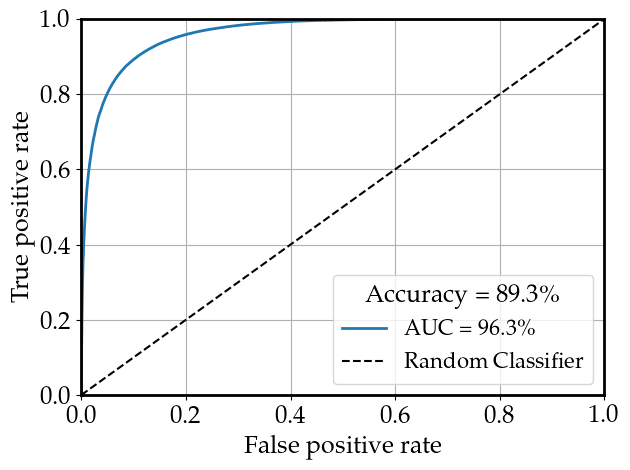

In [9]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.show()

In [10]:
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])

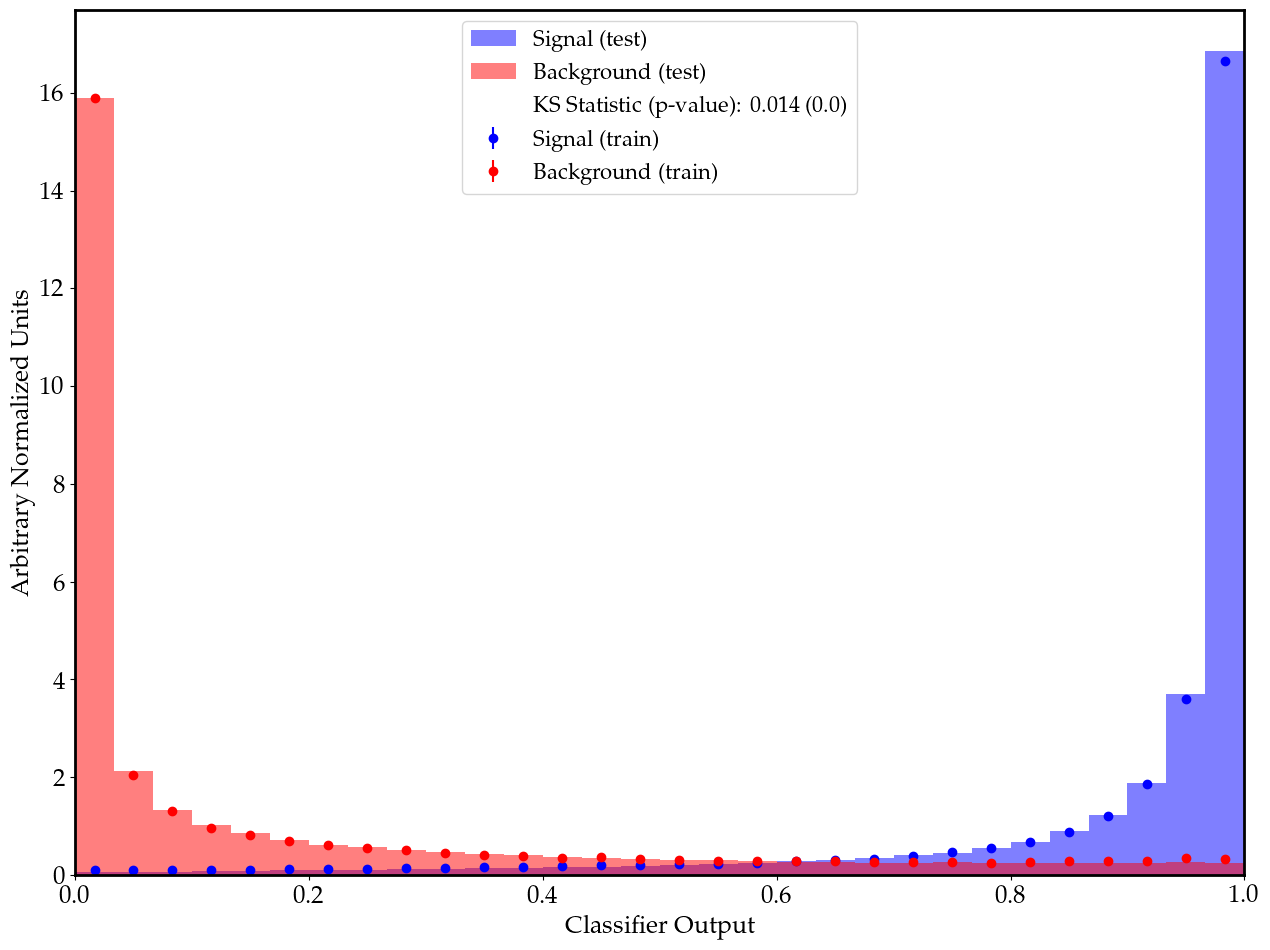

In [11]:
fig